<a href="https://colab.research.google.com/github/jason-zl190/deeplearning/blob/master/test_vgg19_extract_features_from_an_intermediate_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Reference](https://github.com/fchollet/deep-learning-models)

## Data Preparation

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
#tf.enable_eager_execution()

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import Model

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

TensorFlow 2.x selected.


In [0]:
# TensorFlow Better Bicubic Downsample

def bicubic_kernel(x, a=-0.5):
  """https://clouard.users.greyc.fr/Pantheon/experiments/rescaling/index-en.html#bicubic"""
  if abs(x) <= 1:
    return (a + 2)*abs(x)**3 - (a + 3)*abs(x)**2 + 1
  elif 1 < abs(x) and abs(x) < 2:
    return a*abs(x)**3 - 5*a*abs(x)**2 + 8*a*abs(x) - 4*a 
  else:
    return 0

def build_filter(factor):
  size = factor*4
  k = np.zeros((size))
  for i in range(size):
    x = (1/factor)*(i- np.floor(size/2) +0.5)
    k[i] = bicubic_kernel(x)
  k = k / np.sum(k)
  # make 2d
  k = np.outer(k, k.T)
  k = tf.constant(k, dtype=tf.float32, shape=(size, size, 1, 1))
  return tf.concat([k, k, k], axis=2)

def apply_bicubic_downsample(x, filter, factor):
  """Downsample x by a factor of factor, using the filter built by build_filter()
  x: a rank 4 tensor with format NHWC
  filter: from build_filter(factor)
  factor: downsampling factor (ex: factor=2 means the output size is (h/2, w/2))
  """
  # using padding calculations from https://www.tensorflow.org/api_guides/python/nn#Convolution
  filter_height = factor*4
  filter_width = factor*4
  strides = factor
  pad_along_height = max(filter_height - strides, 0)
  pad_along_width = max(filter_width - strides, 0)
  # compute actual padding values for each side
  pad_top = pad_along_height // 2
  pad_bottom = pad_along_height - pad_top
  pad_left = pad_along_width // 2
  pad_right = pad_along_width - pad_left
  # apply mirror padding
  x = tf.pad(x, [[0,0], [pad_top,pad_bottom], [pad_left,pad_right], [0,0]], mode='REFLECT')
  # downsampling performed by strided conv
  x = tf.nn.depthwise_conv2d(x, filter=filter, strides=[1,strides,strides,1], padding='VALID')
  return x


# First, create the bicubic kernel. This can be reused in multiple downsample operations
k = build_filter(factor=4)

# Downsample x which is a tensor with shape [N, H, W, 3]
#y = apply_bicubic_downsample(x, filter=k, factor=4)

# y now contains x downsampled to [N, H/4, W/4, 3]

In [3]:
ds = tfds.load('oxford_iiit_pet')
dim = tf.constant([224, 224], dtype=tf.int32)
batch_size = 10
num_epochs = 20

ds_train = ds['train'].map(lambda ele: (tf.image.resize_with_crop_or_pad(ele['image'], 224, 224), ele['label']))
ds_train = ds_train.map(lambda x, y: (tf.divide(tf.cast(x, tf.float32), 255), y))
ds_train = ds_train.shuffle(buffer_size = 10 * batch_size).repeat(num_epochs).batch(batch_size)
ds_train = ds_train.map(lambda x, y: (apply_bicubic_downsample(x, filter=k, factor=4), x))
ds_test = ds['test'].map(lambda ele: (tf.image.resize_with_crop_or_pad(ele['image'], 224, 224), ele['label']))
ds_test = ds_test.map(lambda x, y: (tf.divide(tf.cast(x, tf.float32), 255), y))
ds_test = ds_test.shuffle(buffer_size = 10 * batch_size).repeat(num_epochs).batch(batch_size)
ds_test = ds_test.map(lambda x, y: (apply_bicubic_downsample(x, filter=k, factor=4), x))

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/1.1.0. Subsequent calls will reuse this data.


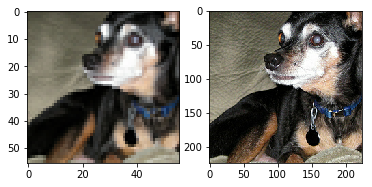

In [4]:
for x,y in ds_train: break

fig,ax = plt.subplots(1, 2)
ax[0].imshow(x[0].numpy())
ax[1].imshow(y[0].numpy())

plt.show()

## VGG19

In [6]:
vgg = tf.keras.applications.VGG19()

574717952/574710816 [==============================] - 16s 0us/step


In [0]:
features = vgg.predict(y)

In [10]:
features.shape

(10, 1000)

In [0]:
model = Model(inputs=vgg.input, outputs=vgg.get_layer('block4_pool').output)
block4_pool_features = model.predict(y)

In [0]:
block4_pool_features